In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from method import IV
from simulator import Simulator
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import pandas as pd
import numpy as np
import quantities as pq
import seaborn as sns
# from exana.statistics import plot_xcorr, permutation_resampling
from tools import savefig, fix_figure, coef_var, corrcoef, despine, set_style
import copy
from IPython.display import display
import statsmodels.api as sm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/mikkel/.virtualenvs/main/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
# analys = pd.read_csv('results/orig_analysis/params_1_analyse_30000.csv')
all_data = pd.read_csv('results/params_2_analyse_30000.csv')

In [6]:
N_pairs = all_data.shape[0]
analys = all_data.loc[(all_data.pfast < 0.01) & (all_data.ppeak < 0.01) & (all_data.hit_rate < 0.9),:]

In [7]:
analys.shape[0] / N_pairs * 100

60.0

In [9]:
def model(x):
    return 1/(1+np.exp(-x))

def norm(x):
#     return (x - np.mean(x)) / np.std(x)
    return (x - min(x)) / (max(x) - min(x))

In [10]:
analys.loc[:,'logit'] = model(analys.loc[:,'logreg'] + analys.loc[:,'logreg_intercept'])

/home/mikkel/.virtualenvs/main/lib/python3.5/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/mikkel/.virtualenvs/main/lib/python3.5/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


# False negatives

In [53]:
TOL = 0.05
include = ['cch', 'iv_cch', 'iv_wald', 'logit', 'weight']
tmp = analys.loc[analys.weight > TOL, include]
fn = pd.concat(
    [tmp.loc[tmp['iv_wald'] <= TOL, 'weight'].rename('IV'),
    tmp.loc[tmp['iv_cch'] <= TOL, 'weight'].rename('CCH IV'),
    tmp.loc[tmp['logit'] <= TOL, 'weight'].rename('LOGIT'),
    tmp.loc[tmp['cch'] <= TOL, 'weight'].rename('CCH')],
    axis=1)

1


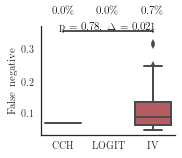

In [94]:
save = True
if save: set_style('article', w=0.485)
if not save: set_style('notebook')
include = ['CCH','LOGIT', 'IV']#, 'CCH IV']
sns.boxplot(data=fn.loc[:,include], palette=['b', 'g', 'r'])
for key, pos_x, pos_y in zip(['CCH'], [0, 1], [.35, 0.9]):
    case = fn.loc[:,['IV']].dropna().values.flatten()
    control = fn.loc[:,[key]].dropna().values.flatten()
    print(len(control))
    pval, observed_diff, diffs = permutation_resampling(case, control, 1000, statistic=np.nanmedian)
    label_diff(pos_x, 2, pos_y, 'p = {:.2f}, $\\Delta$ = {:.3f}'.format(pval, observed_diff))
N = analys.shape[0] / 100
for x, name in zip([0, 1, 2], include):
    text = '{:.1f}\%'.format(len(fn[name].dropna()) / tmp.shape[0])
    plt.text(x, .4, text, ha='center', va='bottom', color='k')
sns.despine()
plt.ylabel('False negative')
if save: savefig(plt.gcf(), 'false_negative')